In [1]:
import pandas as pd
import numpy as np
import mne
from mne.time_frequency import psd_array_welch
from pymatreader import read_mat
from matplotlib import pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro
import seaborn as sns
import pylab
import scipy
from itertools import product
from scipy.stats import iqr

In [2]:
import warnings
from mne import create_info
from mne.io import RawArray
from mne.viz.topomap import _add_colorbar
from mne.viz import plot_topomap
from mpl_toolkits.axes_grid1 import make_axes_locatable


import warnings
from mne import create_info
from mne.io import RawArray
from mne.viz.topomap import _add_colorbar
from mne.viz import plot_topomap
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_values_topomap(value_dict, montage, axes, colorbar=True, cmap='GnBu',
                        vmin=None, vmax=None, names=None, image_interp='linear', side_cb="right",
                        sensors=True, show_names=True, format='%2.1e', cbar_title='', **kwargs):
    if names is None:
        names = montage.ch_names

    info = create_info(names, sfreq=256, ch_types="eeg")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        RawArray(np.zeros((len(names), 1)), info, copy=None, verbose=False).set_montage(montage)

    im = plot_topomap([value_dict[ch] for ch in names], pos=info, show=False, image_interp=image_interp,
                      sensors=sensors, res=64, axes=axes, names=None, cmap=cmap, vlim=(vmin,vmax),**kwargs)

    if colorbar:
        try:
            cbar, cax = _add_colorbar(axes, im[0], cmap, pad=.05,
                                      format=format, side=side_cb)
            axes.cbar = cbar
            cbar.ax.tick_params(labelsize=10)
            cax.set_ylabel(cbar_title,fontsize=10)

        except TypeError:
            pass

    return im

In [3]:
def plot_topo(means_stat, stat, **kwargs):
    dict_topomap = dict(zip(means_stat['channel'], means_stat[stat]))
    channel_names = list(means_stat['channel'])
    montage = mne.channels.make_standard_montage("GSN-HydroCel-129")
    fig, axes = plt.subplots(1,1,figsize=(15,5))
    plot_values_topomap(dict_topomap, montage, axes, names=channel_names, **kwargs)

# Dataframe creation

In [4]:
ab_ica_pt_selection = pd.read_excel('/Users/lina_01/Desktop/ab_ica/AB_ICA_pt_table.xlsx')

In [4]:
psd_dfs = []
kinds = ['original', 'AB', 'ICA']
seg_types = ['clean', 'saccade']
path = 'C:/Users/dsrish/Desktop/fieldtrip-20220208'
pts = list(ab_ica_pt_selection['pt'])

for kind in kinds:
    for pt in pts:
        annot_file = f'/Users/dsrish/Desktop/ds_msc_project/manual_annot_AB_ICA_{pt}.csv'
        for seg_type in seg_types:
            annotations = mne.read_annotations(annot_file)
            times = {}
            for annot in annotations:
                times['onset'] = np.array([annot['onset'] for annot in annotations if annot['description']==seg_type])
                times['duration'] = np.array([annot['duration'] for annot in annotations if annot['description']==seg_type])
                times['offset'] = times['onset'] + times['duration']

            crops = []
            for tmin, tmax in zip(times['onset'],times['offset']):
                if kind=='original':
                    raw_file = mne.io.read_raw_fif(f'{path}/{pt}_rest_raw_processed.fif')           

                elif kind=='AB':
                    raw_file_original = mne.io.read_raw_fif(f'{path}/{pt}_rest_raw_processed.fif')
                    AB_mat_outdata = read_mat(f'{path}/{pt}_AB_outdata.mat')
                    AB_mat_outdata = AB_mat_outdata['datatosave_out']['OutData']
                    raw_file = mne.io.RawArray(AB_mat_outdata, raw_file_original.info)

                else:
                    raw_file = mne.io.read_raw_fif(f'{path}/{pt}_rest_raw_ica.fif')
                
                crop = raw_file.crop(tmin=tmin, tmax=tmax)
                crops.append(crop)

            crop_file = mne.concatenate_raws(crops)  

            srate = raw_file.info['sfreq']
            nfft = int(srate/2)
            nperseg = int(0.5*nfft)
            overlap = int(0.25 * nfft)
            psd, freq = psd_welch(crop_file, picks='all', fmin=2, fmax=48, n_fft=nfft, n_per_seg=nperseg, n_overlap=overlap, 
                                  average='mean')
            assert(not np.any(np.isnan(psd)))
            psd = pd.DataFrame(psd)
            psd['pt'] = pt
            psd['channel'] = crop_file.ch_names
            psd['seg_type'] = seg_type
            psd['kind'] = kind
            psd.columns.values[:len(freq)] = freq
            psd_long = pd.melt(psd, id_vars=['pt','channel', 'seg_type', 'kind'], value_vars=list(psd.columns))
            psd_dfs.append(psd_long)

NameError: name 'ab_ica_pt_selection' is not defined

In [6]:
psd_dfs=pd.concat(psd_dfs)

In [7]:
psd_dfs.rename(columns={'variable':'freq', 'pt':'subject_age','value':'psd'}, inplace=True)

In [8]:
psd_dfs.to_csv('C:/Users/dsrish/Desktop/ds_msc_project/psd_dfs.csv')

In [9]:
np.any(np.isnan(psd_dfs.psd))

False

In [6]:
psd_dfs = pd.read_csv('/Users/lina_01/Desktop/ab_ica/psd_dfs.csv')

## Fig 6

In [5]:
diff_dfs_all = pd.read_csv('/Users/lina_01/Desktop/ab_ica/diff_dfs_all.csv')

In [6]:
diff_dfs_all_saccade = diff_dfs_all.loc[diff_dfs_all['seg_type']=='saccade']

In [7]:
diff_dfs_all_clean = diff_dfs_all.loc[diff_dfs_all['seg_type']=='clean']

In [8]:
bands = {'delta':(2,4), 'theta':(4,6), 'low_alpha':(6,9), 'high_alpha':(9,13), 'beta':(13,30), 'gamma':(30,50)}

In [9]:
vmin1 = diff_dfs_all_saccade.log_psd.min()
vmax1 = diff_dfs_all_saccade.log_psd.max()

vmin2 = diff_dfs_all_clean.log_psd.min()
vmax2 = diff_dfs_all_clean.log_psd.max()

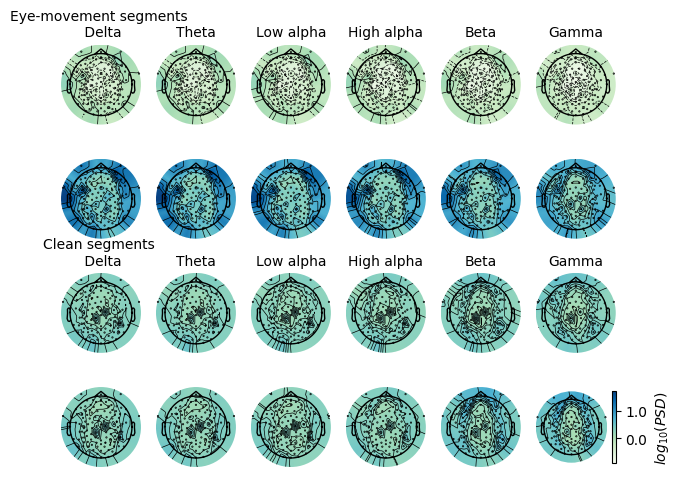

In [10]:
montage = mne.channels.make_standard_montage("GSN-HydroCel-129")
fig, ((ax0,ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10,ax11), (ax12,ax13,ax14,ax15,ax16,ax17),
      (ax18,ax19,ax20,ax21,ax22,ax23)) = plt.subplots(4,6)

diff_dfs_all_saccade_ab =  diff_dfs_all_saccade.loc[diff_dfs_all_saccade['kind']=='ab']

diff_dfs_subsets = []
for band in list(bands.keys()):
    diff_dfs_all_saccade_ab_band = diff_dfs_all_saccade_ab.loc[diff_dfs_all_saccade_ab['band']==band]
    diff_dfs_subsets.append(diff_dfs_all_saccade_ab_band)

dict_topomaps = []
for i, df in zip(list(range(0,6)), diff_dfs_subsets):
    dict_topomap = dict(zip(df['channel'], df['log_psd']))
    dict_topomaps.append(dict_topomap)

channel_names = list(df.channel)

plot_values_topomap(dict_topomaps[0], montage, ax0, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[1], montage, ax1, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[2], montage, ax2, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[3], montage, ax3, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[4], montage, ax4, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[5], montage, ax5, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)

diff_dfs_all_saccade_ica =  diff_dfs_all_saccade.loc[diff_dfs_all_saccade['kind']=='ica']

diff_dfs_subsets = []
for band in list(bands.keys()):
    diff_dfs_all_saccade_ica_band = diff_dfs_all_saccade_ica.loc[diff_dfs_all_saccade_ica['band']==band]
    diff_dfs_subsets.append(diff_dfs_all_saccade_ica_band)

dict_topomaps = []
for i, df in zip(list(range(0,6)), diff_dfs_subsets):
    dict_topomap = dict(zip(df['channel'], df['log_psd']))
    dict_topomaps.append(dict_topomap)

plot_values_topomap(dict_topomaps[0], montage, ax6, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[1], montage, ax7, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[2], montage, ax8, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[3], montage, ax9, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[4], montage, ax10, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[5], montage, ax11, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)

diff_dfs_all_clean_ab = diff_dfs_all_clean.loc[diff_dfs_all_clean['kind']=='ab']

diff_dfs_subsets = []
for band in list(bands.keys()):
    diff_dfs_all_clean_ab_band = diff_dfs_all_clean_ab.loc[diff_dfs_all_clean_ab['band']==band]
    diff_dfs_subsets.append(diff_dfs_all_clean_ab_band)

dict_topomaps = []
for i, df in zip(list(range(0,6)), diff_dfs_subsets):
    dict_topomap = dict(zip(df['channel'], df['log_psd']))
    dict_topomaps.append(dict_topomap)

plot_values_topomap(dict_topomaps[0], montage, ax12, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[1], montage, ax13, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[2], montage, ax14, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[3], montage, ax15, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[4], montage, ax16, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[5], montage, ax17, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)

diff_dfs_all_clean_ica = diff_dfs_all_clean.loc[diff_dfs_all_clean['kind']=='ica']

diff_dfs_subsets = []
for band in list(bands.keys()):
    diff_dfs_all_clean_ica_band = diff_dfs_all_clean_ica.loc[diff_dfs_all_clean_ica['band']==band]
    diff_dfs_subsets.append(diff_dfs_all_clean_ica_band)

dict_topomaps = []
for i, df in zip(list(range(0,6)), diff_dfs_subsets):
    dict_topomap = dict(zip(df['channel'], df['log_psd']))
    dict_topomaps.append(dict_topomap)

plot_values_topomap(dict_topomaps[0], montage, ax18, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[1], montage, ax19, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[2], montage, ax20, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[3], montage, ax21, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[4], montage, ax22, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=False)
plot_values_topomap(dict_topomaps[5], montage, ax23, names=channel_names, vmin=vmin1, vmax=vmax1,format='%2.1f', \
                        colorbar=True, cbar_title='$log_{10}(PSD)$')

ax0.set_title('Eye-movement segments \n Delta',fontsize=10)
ax1.set_title('Theta',fontsize=10)
ax2.set_title('Low alpha',fontsize=10)
ax3.set_title('High alpha',fontsize=10)
ax4.set_title('Beta',fontsize=10)
ax5.set_title('Gamma',fontsize=10)

ax12.set_title('Clean segments \n Delta',fontsize=10)
ax13.set_title('Theta',fontsize=10)
ax14.set_title('Low alpha',fontsize=10)
ax15.set_title('High alpha',fontsize=10)
ax16.set_title('Beta',fontsize=10)
ax17.set_title('Gamma',fontsize=10)

fig.tight_layout()
plt.savefig('psd.png',bbox_inches='tight')

# Statistical analysis

In [3]:
bands = {'delta':(2,4), 'theta':(4,6), 'low_alpha':(6,9), 'high_alpha':(9,13), 'beta':(13,30), 'gamma':(30,50)}

## Saccade

In [4]:
montage = mne.channels.make_standard_montage(kind='GSN-HydroCel-129')
info = mne.create_info(montage.ch_names, sfreq=500, ch_types='eeg')
raw = mne.io.RawArray(np.zeros([129,1]), info).set_montage(montage)

Creating RawArray with float64 data, n_channels=129, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


In [5]:
adj_matrix = mne.channels.find_ch_adjacency(raw.info, ch_type='eeg')[0]
adj_matrix = mne.stats.combine_adjacency(adj_matrix, 6)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 129


In [6]:
threshold = 434

In [7]:
psd_dfs = pd.read_csv('/Users/lina_01/Downloads/psd_dfs.csv')

In [8]:
psd_dfs_saccade = psd_dfs[psd_dfs['seg_type']=='saccade']
psd_dfs_saccade_means = psd_dfs_saccade.groupby(['subject_age', 'channel', 'kind', 'seg_type','freq'])\
                                       .mean().reset_index().drop(columns='Unnamed: 0')

In [9]:
for band_str, band in bands.items():
    psd_dfs_saccade_means.loc[(psd_dfs_saccade_means.freq>=band[0]) & 
                              (psd_dfs_saccade_means.freq<band[1]), 'band'] = band_str

/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_1535/945480151.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'delta' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  psd_dfs_saccade_means.loc[(psd_dfs_saccade_means.freq>=band[0]) &


In [10]:
psd_dfs_saccade_means['log10_psd'] = np.log10(psd_dfs_saccade_means['psd'])
psd_dfs_saccade_means_bands = psd_dfs_saccade_means.groupby(['subject_age', 'channel', 'kind', 'seg_type', 'band'])\
                              .mean().reset_index()

In [ ]:
#original vs AB

In [11]:
X_saccade_ab_original = []
for band in bands:
    psd_dfs_saccade_means_bands_ab = psd_dfs_saccade_means_bands.loc[(psd_dfs_saccade_means_bands['kind']=='AB')
                                                                         & (psd_dfs_saccade_means_bands['band']==band)]
    psd_dfs_saccade_means_bands_ab = psd_dfs_saccade_means_bands_ab[['log10_psd','subject_age','channel']]
    psd_dfs_saccade_means_bands_ab = np.array(psd_dfs_saccade_means_bands_ab.pivot_table(index='subject_age', 
                                                                                       columns='channel', values='log10_psd'))
    
    psd_dfs_saccade_means_bands_original = psd_dfs_saccade_means_bands.loc[(psd_dfs_saccade_means_bands['kind']=='original')
                                                                               & (psd_dfs_saccade_means_bands['band']==band)]
    psd_dfs_saccade_means_bands_original = psd_dfs_saccade_means_bands_original[['log10_psd','subject_age','channel']]
    psd_dfs_saccade_means_bands_original = np.array(psd_dfs_saccade_means_bands_original.pivot_table(index='subject_age', 
                                                                                                     columns='channel', 
                                                                                                     values='log10_psd'))
    X_saccade_ab_original.append([psd_dfs_saccade_means_bands_original, psd_dfs_saccade_means_bands_ab])
    
X_saccade_ab_original = np.array(X_saccade_ab_original).transpose([1,2,3,0])
    
def wilcox_stat_fun(x, y, axis=0):
    return 1/stats.wilcoxon(x,y,axis=axis)[0]
        
w, clusters, clusters_pv, h0 = mne.stats.permutation_cluster_test(X_saccade_ab_original, threshold = 1/threshold, n_permutations=1000, 
                                                                  stat_fun=wilcox_stat_fun, adjacency=adj_matrix)

stat_fun(H1): min=0.005102 max=inf
Running initial clustering …
Found 1 cluster


/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_1535/253075467.py:20: RuntimeWarning: divide by zero encountered in divide
  return 1/stats.wilcoxon(x,y,axis=axis)[0]


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

In [12]:
dfs = []
for i in list(range(len(clusters))):
    clusters_array = np.array(clusters[i])
    df = pd.DataFrame(clusters_array).T
    df['Cluster'] = i
    df = df.rename(columns= {0:'Channel',1:'band'}) 
    dfs.append(df)

In [13]:
heatmap_df = pd.concat(dfs)
heatmap_df = pd.pivot_table(heatmap_df, index='band', columns='Channel', values='Cluster')

<Axes: xlabel='Channel', ylabel='band'>

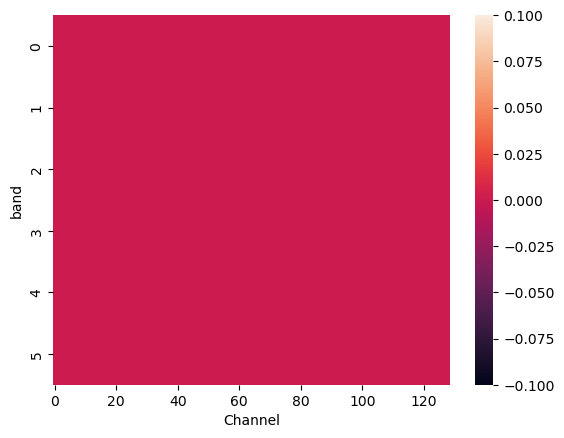

In [14]:
sns.heatmap(heatmap_df,xticklabels=20)

In [138]:
#original vs ICA

In [16]:
X_saccade_ica_original = []
for band in bands:
    psd_dfs_saccade_means_bands_ica = psd_dfs_saccade_means_bands.loc[(psd_dfs_saccade_means_bands['kind']=='ICA')
                                                                         & (psd_dfs_saccade_means_bands['band']==band)]
    psd_dfs_saccade_means_bands_ica = psd_dfs_saccade_means_bands_ica[['log10_psd','subject_age','channel']]
    psd_dfs_saccade_means_bands_ica = np.array(psd_dfs_saccade_means_bands_ica.pivot_table(index='subject_age', 
                                                                                       columns='channel', values='log10_psd'))
    
    psd_dfs_saccade_means_bands_original = psd_dfs_saccade_means_bands.loc[(psd_dfs_saccade_means_bands['kind']=='original')
                                                                               & (psd_dfs_saccade_means_bands['band']==band)]
    psd_dfs_saccade_means_bands_original = psd_dfs_saccade_means_bands_original[['log10_psd','subject_age','channel']]
    psd_dfs_saccade_means_bands_original = np.array(psd_dfs_saccade_means_bands_original.pivot_table(index='subject_age', 
                                                                                                     columns='channel', 
                                                                                                     values='log10_psd'))
    X_saccade_ica_original.append([psd_dfs_saccade_means_bands_original, psd_dfs_saccade_means_bands_ica])
    
X_saccade_ica_original = np.array(X_saccade_ica_original).transpose([1,2,3,0])
    
def wilcox_stat_fun(x, y, axis=0):
    return 1/stats.wilcoxon(x,y,axis=axis)[0]
        
w, clusters, clusters_pv, h0 = mne.stats.permutation_cluster_test(X_saccade_ica_original, threshold = 1/threshold, n_permutations=1000, 
                                                                  stat_fun=wilcox_stat_fun, adjacency=adj_matrix)

stat_fun(H1): min=0.003311 max=inf
Running initial clustering …
Found 1 cluster


/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_1535/1127586541.py:20: RuntimeWarning: divide by zero encountered in divide
  return 1/stats.wilcoxon(x,y,axis=axis)[0]


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

In [20]:
clusters_pv

array([0.001])

In [17]:
dfs = []
for i in list(range(len(clusters))):
    clusters_array = np.array(clusters[i])
    df = pd.DataFrame(clusters_array).T
    df['Cluster'] = i
    df = df.rename(columns= {0:'Channel',1:'band'}) 
    dfs.append(df)

In [18]:
heatmap_df = pd.concat(dfs)
heatmap_df = pd.pivot_table(heatmap_df, index='band', columns='Channel', values='Cluster')

<Axes: xlabel='Channel', ylabel='band'>

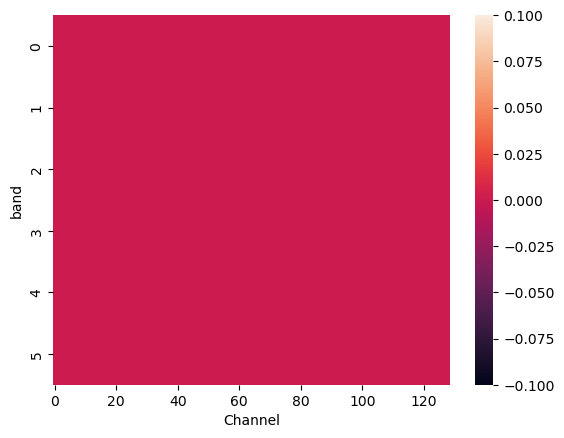

In [19]:
sns.heatmap(heatmap_df,xticklabels=20)

## Clean

In [21]:
psd_dfs_clean = psd_dfs[psd_dfs['seg_type']=='clean']
psd_dfs_clean_means = psd_dfs_clean.groupby(['subject_age', 'channel', 'kind', 'seg_type','freq'])\
                                       .mean().reset_index().drop(columns='Unnamed: 0')

In [22]:
for band_str, band in bands.items():
    psd_dfs_clean_means.loc[(psd_dfs_clean_means.freq>=band[0]) & 
                              (psd_dfs_clean_means.freq<band[1]), 'band'] = band_str

/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_1535/3516232728.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'delta' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  psd_dfs_clean_means.loc[(psd_dfs_clean_means.freq>=band[0]) &


In [23]:
psd_dfs_clean_means['log10_psd'] = np.log10(psd_dfs_clean_means['psd'])
psd_dfs_clean_means_bands = psd_dfs_clean_means.groupby(['subject_age', 'channel', 'kind', 'seg_type', 'band'])\
                              .mean().reset_index()

In [ ]:
#ab vs original

In [24]:
X_clean_ab_original = []
for band in bands:
    psd_dfs_clean_means_bands_ab = psd_dfs_clean_means_bands.loc[(psd_dfs_clean_means_bands['kind']=='AB')
                                                                         & (psd_dfs_clean_means_bands['band']==band)]
    psd_dfs_clean_means_bands_ab = psd_dfs_clean_means_bands_ab[['log10_psd','subject_age','channel']]
    psd_dfs_clean_means_bands_ab = np.array(psd_dfs_clean_means_bands_ab.pivot_table(index='subject_age', 
                                                                                       columns='channel', values='log10_psd'))
  
    psd_dfs_clean_means_bands_original = psd_dfs_clean_means_bands.loc[(psd_dfs_clean_means_bands['kind']=='original')
                                                                               & (psd_dfs_clean_means_bands['band']==band)]
    psd_dfs_clean_means_bands_original = psd_dfs_clean_means_bands_original[['log10_psd','subject_age','channel']]
    psd_dfs_clean_means_bands_original = np.array(psd_dfs_clean_means_bands_original.pivot_table(index='subject_age', columns='channel',
                                                                                           values='log10_psd'))
    
    X_clean_ab_original.append([psd_dfs_clean_means_bands_original, psd_dfs_clean_means_bands_ab])

X_clean_ab_original = np.array(X_clean_ab_original).transpose([1,2,3,0])
    
def wilcox_stat_fun(x, y, axis=0):
    return 1/stats.wilcoxon(x,y,axis=axis)[0]
        
w, clusters, clusters_pv, h0 = mne.stats.permutation_cluster_test(X_clean_ab_original, threshold = 1/threshold, n_permutations=1000, 
                                                                  stat_fun=wilcox_stat_fun, adjacency=adj_matrix)

stat_fun(H1): min=0.003846 max=inf
Running initial clustering …
Found 1 cluster


/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_1535/30554138.py:20: RuntimeWarning: divide by zero encountered in divide
  return 1/stats.wilcoxon(x,y,axis=axis)[0]


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

In [25]:
clusters_pv

array([0.001])

In [ ]:
#ICA vs original

In [28]:
X_clean_ica_original = []
for band in bands:
    psd_dfs_clean_means_bands_ica = psd_dfs_clean_means_bands.loc[(psd_dfs_clean_means_bands['kind']=='ICA')
                                                                         & (psd_dfs_clean_means_bands['band']==band)]
    psd_dfs_clean_means_bands_ica = psd_dfs_clean_means_bands_ica[['log10_psd','subject_age','channel']]
    psd_dfs_clean_means_bands_ica = np.array(psd_dfs_clean_means_bands_ica.pivot_table(index='subject_age', 
                                                                                       columns='channel', values='log10_psd'))
  
    psd_dfs_clean_means_bands_original = psd_dfs_clean_means_bands.loc[(psd_dfs_clean_means_bands['kind']=='original')
                                                                               & (psd_dfs_clean_means_bands['band']==band)]
    psd_dfs_clean_means_bands_original = psd_dfs_clean_means_bands_original[['log10_psd','subject_age','channel']]
    psd_dfs_clean_means_bands_original = np.array(psd_dfs_clean_means_bands_original.pivot_table(index='subject_age', columns='channel',
                                                                                           values='log10_psd'))
    
    X_clean_ica_original.append([psd_dfs_clean_means_bands_original, psd_dfs_clean_means_bands_ica])

X_clean_ica_original = np.array(X_clean_ica_original).transpose([1,2,3,0])
    
def wilcox_stat_fun(x, y, axis=0):
    return 1/stats.wilcoxon(x,y,axis=axis)[0]
        
w, clusters, clusters_pv, h0 = mne.stats.permutation_cluster_test(X_clean_ica_original, threshold = 1/threshold, n_permutations=1000, 
                                                                  stat_fun=wilcox_stat_fun, adjacency=adj_matrix)

stat_fun(H1): min=0.001898 max=inf
Running initial clustering …
Found 1 cluster


/var/folders/cl/8cj5mvt51nbchvsgng871t400000gn/T/ipykernel_1535/2304628416.py:20: RuntimeWarning: divide by zero encountered in divide
  return 1/stats.wilcoxon(x,y,axis=axis)[0]


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]